In [1]:

%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler



In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:26: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 20
cross = True
return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift, cross)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models
%reload_ext autoreload
%autoreload 2
"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
"""
param_grid_NN = {
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [50],  
    'batch_size': [32, 64]
}
#param_grid_NN =  {'batch_size': [64], 'epochs': [50], 'optimizer': ['rmsprop']}

NN_model, best_params, X_test_scaled = optimize_and_train_NN(X_train, y_train, X_eval, y_eval, X_test, param_grid_NN, cross)



param_grid_alpha = {'alpha': [0.1, 1.0, 10.0]}
#param_grid_alpha = {'alpha': [1.0]}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha, cross)


param_grid_lgb = {
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63, 127, 255]
}


lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb, cross)


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 32, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3044/3044 ━━━━━━━━━━━━━━━━━━━━ 3s 900us/step - accuracy: 0.5422 - loss: 0.2478 - val_accuracy: 0.5321 - val_loss: 0.2502
Epoch 2/50
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 3s 850us/step - accuracy: 0.5615 - loss: 0.2437 - val_accuracy: 0.5191 - val_loss: 0.2536
Epoch 3/50
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 3s 853us/step - accuracy: 0.5719 - loss: 0.2411 - val_accuracy: 0.5201 - val_loss: 0.2537
Epoch 4/50
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step - accuracy: 0.5812 - loss: 0.2386 - val_accuracy: 0.5196 - val_loss: 0.2578
Epoch 5/50
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 3s 852us/step - accuracy: 0.5871 - loss: 0.2364 - val_accuracy: 0.5205 - val_loss: 0.2574
Epoch 6/50
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step - accuracy: 0.6002 - loss: 0.2333 - val_accuracy: 0.5114 - val_loss: 0.2599
Epoch 7/50
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 3s 845us/step - accuracy: 0.6053 - loss: 0.2309 - val_accuracy: 0.5142 - val_loss: 0.2638
Epoch 8/50
3044/3044 ━━━━━━━━━━━━━━━━━━━━ 3s 857us/step - accuracy: 0.6152 - loss: 0.22

In [7]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


6087/6087 ━━━━━━━━━━━━━━━━━━━━ 2s 403us/step
Ridge Classifier:
Accuracy: 0.5262841740469772
Confusion Matrix:
[[66596 32797]
 [59471 35911]]
Precision: 52.26611166094196
Recall: 37.6496613616825
F1 Score: 43.76988238161984
MSE: 47.37158259530227
RMSE: 68.82701693034667


LightGBM Classifier:
Accuracy: 0.5299807470157875
Confusion Matrix:
[[59634 39759]
 [51789 43593]]
Precision: 52.299884825799026
Recall: 45.703591872680384
F1 Score: 48.77975091476719
MSE: 47.001925298421256
RMSE: 68.55795015781996


Neural Network:
Accuracy: 0.5169811320754717
Confusion Matrix:
[[57999 41394]
 [52686 42696]]
Precision: 50.77417053157332
Recall: 44.763162860917156
F1 Score: 47.57956672907194
MSE: 48.301886792452834
RMSE: 69.4995588420911




In [8]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [9]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'ridge': ridge_best,
    'NN': NN_model,
    'benchmark': None
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}


In [24]:
%reload_ext autoreload
%autoreload 2

signals_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}

portfolio_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col, cross, top_percentile=70, bottom_percentile=30) 
    assets_df = pd.concat([best_assets, worst_assets])
    assets_df['update_value'] = 0
    assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
    assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

    pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
    signals_dfs[name].update(pivot_df)

    portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)


6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 409us/step


In [25]:
lgb_weights = portfolio_dfs['lgb']
ridge_weights = portfolio_dfs['ridge']
NN_weights = portfolio_dfs['NN']
benchmark_weights = portfolio_dfs['benchmark']




lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read



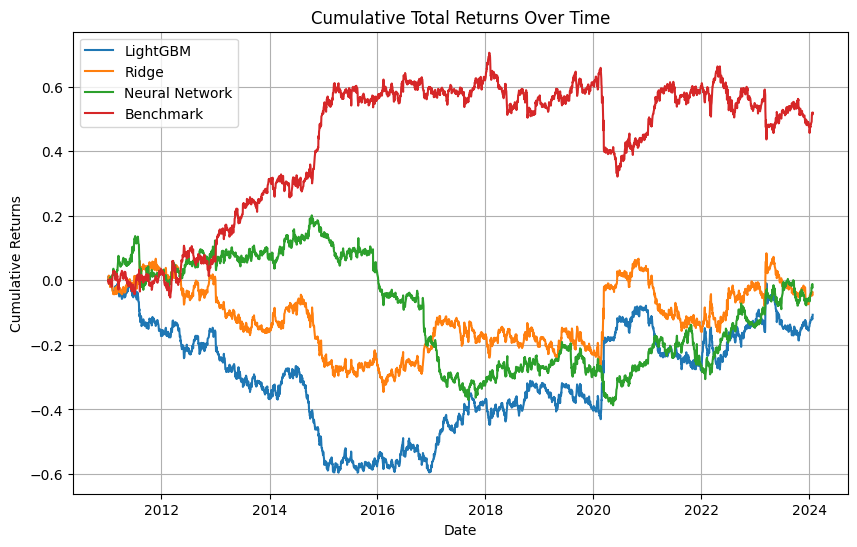

In [26]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)

lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [27]:
%reload_ext autoreload
%autoreload 2
ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
    "Ridge": ridge_metrics,
    "LightGBM": lgb_metrics,
    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df = pd.DataFrame(metrics).T  


In [28]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Yearly Sharpe Ratio,Max Drawdown,Yearly Volatility,Calmar Ratio,Skewness,Kurtosis,Yearly Trades,Yearly Turnover,Yearly Transaction Costs
Ridge,-0.002826,0.119001,-0.023749,-0.338342,0.119001,-0.008353,0.788337,7.331971,581.785714,82.101753,0.008210
LightGBM,-0.008010,0.114724,-0.069820,-0.456619,0.114724,-0.017542,0.636360,6.422720,582.214286,85.123436,0.008512
Neural Network,-0.001600,0.113297,-0.014126,-0.444954,0.113297,-0.003597,-0.345231,4.915359,583.428571,142.118303,0.014212
Benchmark,0.038992,0.123392,0.316002,-0.318776,0.123392,0.122318,-0.864481,6.631423,530.642857,45.405019,0.004541


In [29]:
ridge_turnover = ridge_weights.diff().abs().sum(axis=1)
lgb_turnover = lgb_weights.diff().abs().sum(axis=1)
NN_turnover = NN_weights.diff().abs().sum(axis=1)
bench_turnover = benchmark_weights.diff().abs().sum(axis=1)


ridge_trans_cost = ridge_turnover * 0.01 *0.01
lgb_trans_cost = lgb_turnover * 0.01 * 0.01
NN_trans_cost = NN_turnover * 0.01 * 0.01
bench_trans_cost = bench_turnover * 0.01 * 0.01

ridge_adjusted_returns = ridge_total_returns - ridge_trans_cost
lgb_adjusted_returns = lgb_total_returns - lgb_trans_cost
NN_adjusted_returns = NN_total_returns - lgb_trans_cost
bench_adjusted_returns = benchmark_total_returns - bench_trans_cost

ridge_cumulative_total_returns_post_cost = ridge_adjusted_returns.cumsum()
lgb_cumulative_total_returns_post_cost = lgb_adjusted_returns.cumsum()
NN_cumulative_total_returns_post_cost = NN_adjusted_returns.cumsum()
bench_cumulative_total_returns_post_cost = bench_adjusted_returns.cumsum()



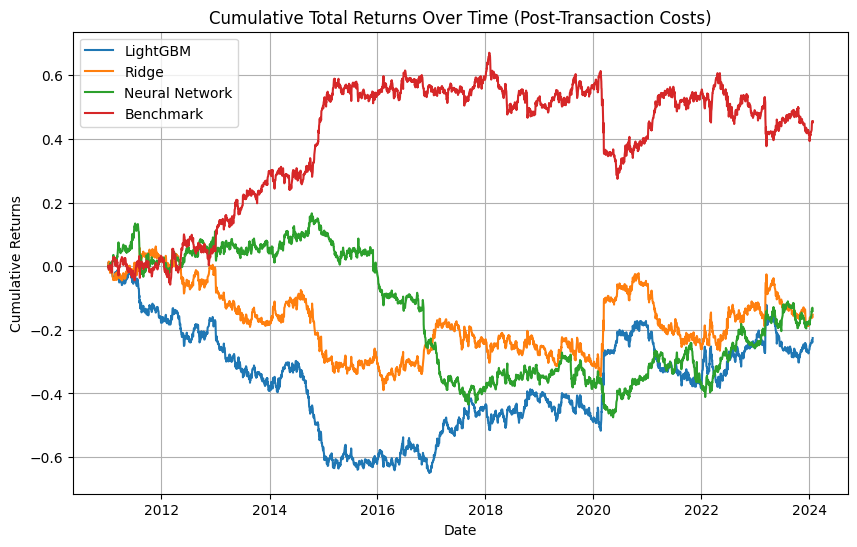

In [30]:



# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns_post_cost, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_post_cost, label='Ridge')
plt.plot(NN_cumulative_total_returns_post_cost, label='Neural Network')
plt.plot(bench_cumulative_total_returns_post_cost, label='Benchmark')
plt.title('Cumulative Total Returns Over Time (Post-Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

